In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt


# Иморт данных
```specter``` и ```mask``` имеют тип ```numpy.ndarray```. Размеры 512, 512, 237

In [4]:
specter = np.load('12.npy')
mask = np.load('12_mask.npy')

**Создание тренировочных и тестовых выборок для дальнейшей _обыкновенной_ классификации.** Код взят из методички

In [5]:
x_train = []
y_train = []
x_test = []
y_test = []

height = specter.shape[0]
width = specter.shape[1]
ordered_positions = np.array(np.meshgrid(np.arange(height), np.arange(width))).T.reshape(-1, 2)

train_indices, test_indices = train_test_split(ordered_positions, train_size=0.05, shuffle=True)

for idx in train_indices:
    x_train.append(specter[idx[0], idx[1], ::])
    y_train.append(mask[idx[0], idx[1]])    
    
for idx in test_indices:
    x_test.append(specter[idx[0], idx[1], ::])
    y_test.append(mask[idx[0], idx[1]])    
    
x_train = np.array(x_train, copy=False)
y_train = np.array(y_train, copy=False)
x_test = np.array(x_test, copy=False)
y_test = np.array(y_test, copy=False)

In [6]:
x_train.shape

(13107, 237)

Всего имеется 237 признаков. В тренировочной выборке 13107 экземпляров, а в тестовой 249037. Выборки не являются типом ```list```!

**Попробуем создать и протестировать классификатор со всеми признаками** с применением кросс-валидации. 

In [4]:
clf = DecisionTreeClassifier()
cvs = cross_val_score(clf, x_train, y_train, cv=5)
cvs

array([0.7238749 , 0.71815408, 0.7344525 , 0.71384968, 0.72338802])

Эксперементировать нужно с различным количетсвом выбранных признаков. **Нужно будет создать функцию!!!**. Принимать она должна диапазон выбранных признаков, а возвращать точность модели. 

# Нахождение оптимальных признаков для классификации
Для начала попробуем найти оптимальные признаки с помощью ```SelectKBest```. 

Следует создать **DataFrame**, имеющихся тренировочных данных.

In [5]:
names = []
for i in range(len(x_train[0])):
    names.append(i)

x = pd.DataFrame(x_train, columns = names)
y = pd.DataFrame(y_train)

In [6]:
selecter = SelectKBest(score_func=chi2)
fit = selecter.fit(x.values, y.values)
all_features = pd.DataFrame(data=fit.scores_, index=x.columns, columns=['score'])
all_features['number'] = pd.Series(range(x.shape[1]), index=all_features.index)

Класс. В ```all_features``` получили оценку значимости всех признаков тренировочной выборки. Теперь нужно выбрать из них только самые лучшие.

In [ ]:
best_features = all_features.nlargest(238, "score")

Теперь у нас есть алгоритм вывода лучших фич для классификации по мнению ```SelectKBest```. Стоит попробовать произвести классификацию, используя только данные признаки. Но видимо для этого стоит изменить тестовые и тренировочные выборки, оставив только самые необходимые признаки. 

Потом этим займемся. Наверное стоит сохранить признаки в список.

In [10]:
list_feature_K = []
for feature in best_features['number']:
    list_feature_K.append(feature)

# Классификация с использованием лучших признаков
Для классификации выберем тот же ```DecisionTreeClassifier```. Нужно создать новые тренировчные выборки, в которых останутся лишь необходимые признаки. 

In [11]:
tx_train = x_train.transpose()
tx_test = x_test.transpose()
new_x_train = []
new_x_test = []
for i in list_feature_K:
    new_x_train.append(tx_train[i])
    new_x_test.append(tx_test[i])
nx_train = np.array(new_x_train, copy=False).transpose()
nx_test = np.array(new_x_test, copy=False).transpose()

In [12]:
model = DecisionTreeClassifier()
clf = model.fit(nx_train, y_train)

In [13]:
accuracy = clf.score(nx_test, y_test)
accuracy

0.7379746784614334

Результат откровенно говоря не очень. Наверное 20 лучших признаков просто не достаточно в данном случае. Но так или иначе можно приступать к реализации функции, которая покажет оптимальное количество признаков.

# def FindBestKFeatures
Функция принимает два аргумента: минамальное количество и максимальное количество признаков, которое нам нужно протестировать. За основу берется тот же алгоритм, что написан выше. Создается **DataFrame**, применяется ```MLPClassifier```, но только дальше берется различное количество наилучших признаков и с помощью кросс-валидации дается итоговая оценка классификации. Функция возвращает два списка: в одном количество взятых признаков, а в другом соответсвующий результат взятому количетсву признаков.

In [14]:
def FindBestKFeatures(Kmin, Kmax):
    names = []  
    num = []
    results = []
    for i in range(len(x_train[0])):
        names.append(i)

    x = pd.DataFrame(x_train, columns = names)
    y = pd.DataFrame(y_train)
    
    selecter = SelectKBest(score_func=chi2)
    fit = selecter.fit(x.values, y.values)
    all_features = pd.DataFrame(data=fit.scores_, index=x.columns, columns=['score'])
    all_features['number'] = pd.Series(range(x.shape[1]), index=all_features.index)
    
    for K in range (Kmin, Kmax):
        num.append(K)
        best_features = all_features.nlargest(K, "score")
        
        list_feature_K = []
        for feature in best_features['number']:
            list_feature_K.append(feature)
        
        tx_train = x_train.transpose()
        tx_test = x_test.transpose()
        new_x_train = []
        new_x_test = []
        for i in list_feature_K:
            new_x_train.append(tx_train[i])
            new_x_test.append(tx_test[i])
        nx_train = np.array(new_x_train, copy=False).transpose()
        nx_test = np.array(new_x_test, copy=False).transpose()
        
        model = MLPClassifier()
        cvs = cross_val_score(clf, nx_train, y_train, cv=5)
        tmp = sum(cvs)
        res = tmp/len(cvs)
        results.append(res)
        print("Итерация для", K, 'признаков закончена')
    return(num, results)

In [15]:
num, accuracy = FindBestKFeatures(20, 230)

Итерация для 20 признаков закончена
Итерация для 21 признаков закончена
Итерация для 22 признаков закончена
Итерация для 23 признаков закончена
Итерация для 24 признаков закончена
Итерация для 25 признаков закончена
Итерация для 26 признаков закончена
Итерация для 27 признаков закончена
Итерация для 28 признаков закончена
Итерация для 29 признаков закончена
Итерация для 30 признаков закончена
Итерация для 31 признаков закончена
Итерация для 32 признаков закончена
Итерация для 33 признаков закончена
Итерация для 34 признаков закончена
Итерация для 35 признаков закончена
Итерация для 36 признаков закончена
Итерация для 37 признаков закончена
Итерация для 38 признаков закончена
Итерация для 39 признаков закончена
Итерация для 40 признаков закончена
Итерация для 41 признаков закончена
Итерация для 42 признаков закончена
Итерация для 43 признаков закончена
Итерация для 44 признаков закончена
Итерация для 45 признаков закончена
Итерация для 46 признаков закончена
Итерация для 47 признаков за

Извлечем лучший результат

In [16]:
best = 0
c = 0
numb = 0
for a in accuracy:
    if a > best:
        best = a
        numb = num[c]
    c+=1
print("Лучший результат показали", numb, 'признаков. Accuracy =', best)

Лучший результат показали 167 признаков. Accuracy = 0.7446406728963477


# Результаты
## DataFrame с признаками и их информативностью, отсортированный по убыванию

In [17]:
best_features

,score,number
136,34782.500801,136
135,34706.851147,135
137,34536.279696,137
134,33720.294293,134
138,33627.502198,138
...,...,...
111,5305.993090,111
69,5286.560921,69
107,5240.934829,107
110,5229.831857,110


## График, показывающий зависимость результата оценки от числа выбранных признаков

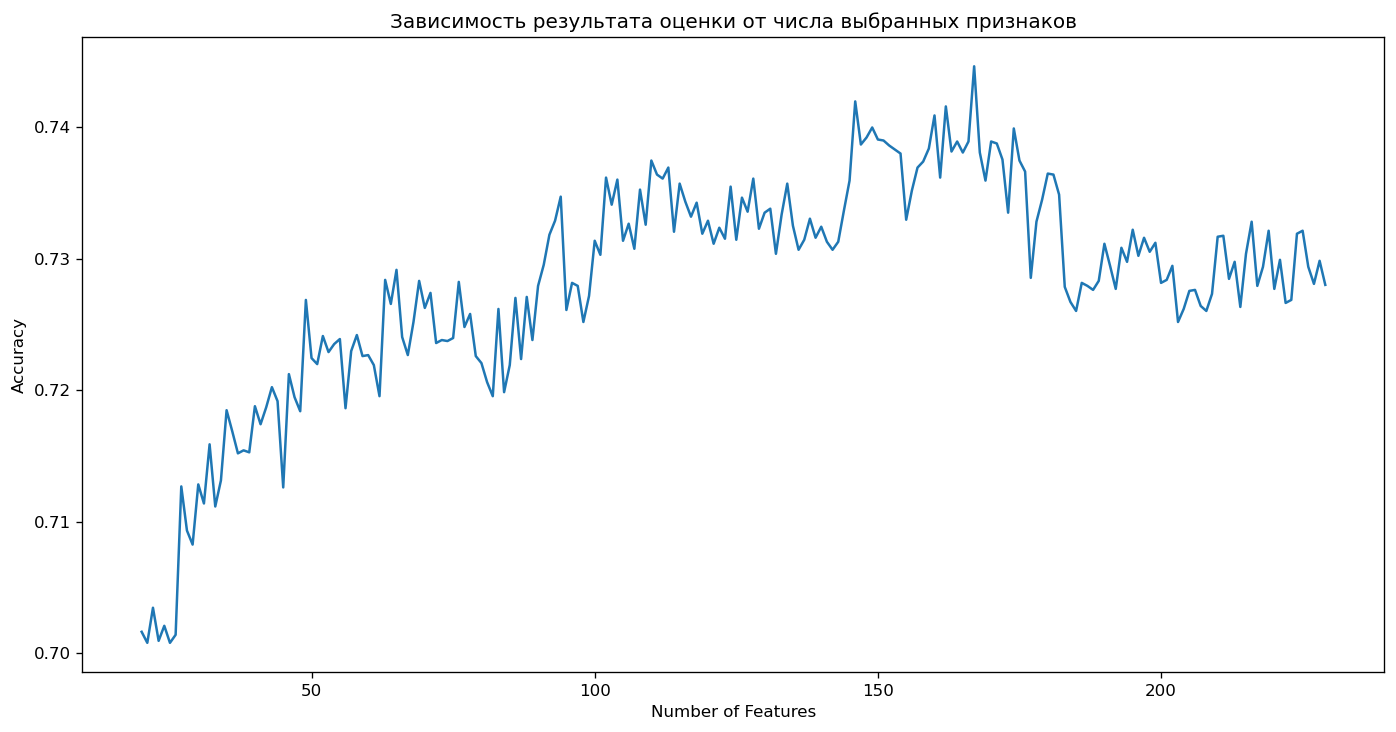

In [18]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(14, 7), dpi=120)

plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Зависимость результата оценки от числа выбранных признаков")
ax1.plot(num, accuracy)

## Таблица содержащая метрики для лучшей модели

In [26]:
best_features = all_features.nlargest(169, "score")
list_feature_K = []

list_feature_K.append(feature)
        
tx_train = x_train.transpose()
tx_test = x_test.transpose()
new_x_train = []
new_x_test = []
for i in list_feature_K:
    new_x_train.append(tx_train[i])
    new_x_test.append(tx_test[i])
nx_train = np.array(new_x_train, copy=False).transpose()
nx_test = np.array(new_x_test, copy=False).transpose()
        
model = MLPClassifier()
model = model.fit(nx_train, y_train)
pred = model.predict(nx_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3977
           5       0.00      0.00      0.00     33709
           7       0.70      1.00      0.82    173419
          10       0.00      0.00      0.00     37932

    accuracy                           0.70    249037
   macro avg       0.17      0.25      0.21    249037
weighted avg       0.48      0.70      0.57    249037



C:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Визуализация предсказания

Text(0.5, 1.0, 'Predictions')

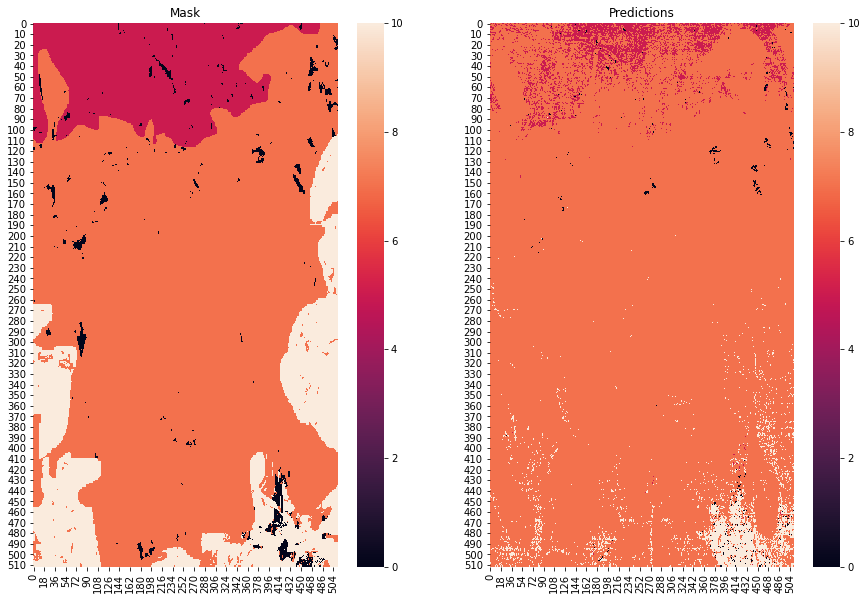

In [30]:
cls = MLPClassifier()
cls.fit(x_train, y_train)
cls.score(x_test, y_test)

train_preds = cls.predict(x_train)
test_preds = cls.predict(x_test)

predictions_map = np.zeros_like(mask)

for (y, x), pred in zip(train_indices, train_preds):
    predictions_map[y, x] = pred
    
for (y, x), pred in zip(test_indices, test_preds):
    predictions_map[y, x] = pred
    
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
sns.heatmap(mask, ax=ax1)
sns.heatmap(predictions_map, ax=ax2)
ax1.set_title('Mask')
ax2.set_title('Predictions')